In [8]:
# IMPORTS

import pandas as pd
import h5py
import numpy as np
import sys
import matplotlib.pyplot as plt
import neurokit2 as nk
import random
import networkx as nx
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx # Visualization
import matplotlib.pyplot as plt
from torch.nn import Linear                   # Define layers
from torch_geometric.nn import GCNConv
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d 
import pywt # pip install PyWavelets
from scipy.signal import medfilt
import cv2 # pip install opencv-python  

In [2]:
# CARREGAR OS DADOS

def carregar_ecgs(normal, umdavb, rbbb, lbbb, sb, st, af, filtrado):

    caminho_arquivo = "../Projeto/Database/exams.csv"
    dados = pd.read_csv(caminho_arquivo)
    arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                    "exams_part2.hdf5", "exams_part3.hdf5", "exams_par4.hdf5", "exams_part5.hdf5",
                    "exams_part6.hdf5", "exams_part7.hdf5", "exams_par8.hdf5", "exams_part9.hdf5",
                    "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                    "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

    ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]



    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    caminho_interferencias = "../Projeto/Database/resultados_interferencia.csv"
    interferencias = pd.read_csv(caminho_interferencias)
    interferencias_ids = interferencias['exam_id'].tolist()

    ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == True)]
    
    ecg_umdavb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]

    print("Tirando Interferência:")
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
    ecg_umdavb_id = dados.iloc[ecg_umdavb_linhas, 0].tolist()
    ecg_rbbb_id = dados.iloc[ecg_rbbb_linhas, 0].tolist()
    ecg_lbbb_id = dados.iloc[ecg_lbbb_linhas, 0].tolist()
    ecg_sb_id = dados.iloc[ecg_sb_linhas, 0].tolist()
    ecg_st_id = dados.iloc[ecg_st_linhas, 0].tolist()
    ecg_af_id = dados.iloc[ecg_af_linhas, 0].tolist()

    random.seed(42) 

    ecg_normal_sample = random.sample(ecg_normal_id, normal) if len(ecg_normal_id) >= normal else ecg_normal_id
    ecg_umdavb_sample = random.sample(ecg_umdavb_id, umdavb) if len(ecg_umdavb_id) >= umdavb else ecg_umdavb_id
    ecg_rbbb_sample = random.sample(ecg_rbbb_id, rbbb) if len(ecg_rbbb_id) >= rbbb else ecg_rbbb_id
    ecg_lbbb_sample = random.sample(ecg_lbbb_id, lbbb) if len(ecg_lbbb_id) >= lbbb else ecg_lbbb_id
    ecg_sb_sample = random.sample(ecg_sb_id, sb) if len(ecg_sb_id) >= sb else ecg_sb_id
    ecg_st_sample = random.sample(ecg_st_id, st) if len(ecg_st_id) >= st else ecg_st_id
    ecg_af_sample = random.sample(ecg_af_id, af) if len(ecg_af_id) >= af else ecg_af_id

    ids_ecgs = ecg_normal_sample + ecg_umdavb_sample + ecg_rbbb_sample + ecg_lbbb_sample + ecg_sb_sample + ecg_st_sample + ecg_af_sample

    print("Número de ecgs pra usar:", len(ids_ecgs))

    
    if filtrado == True: arquivos_hdf5 = ["/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_0_1.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5"]
    
    else: arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5']
        
    

    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            # Obter os IDs dos exames
            exam_ids = np.array(f['exam_id'])

            # Encontrar o índice correspondente ao exam_id de interesse
            exam_index = np.where(exam_ids == exam_id)[0]

            if len(exam_index) == 0:
                raise ValueError("Exam ID não encontrado.")
            else:
                exam_index = exam_index[0]
                # Acessar os tracings de ECG correspondentes ao exam_index
                exam_tracings = f['tracings'][exam_index]
                # Preencher tracings nulos com epsilon
                return exam_tracings

    exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

    # Lista para armazenar todos os tracings de ECG
    all_tracings = []

    # Obter os tracings de ECG para cada exam_id e armazenar na lista
    for exam_id in exam_ids_to_cluster:
        found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    found = True  # Sinalizador para indicar que o exame foi encontrado
                    break  # Se encontrou, não precisa continuar buscando nos outros arquivos
            except ValueError as e:
                i = 0
            except Exception as e:
                i = 0
        
        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

    # Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
    print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
    print(f"Número total de traçados processados: {len(all_tracings)}")

    # X será um array com um único array dentro, contendo todos os números do tracings.T
    X = np.array(all_tracings)
    return X

Número de linhas ecg_normal_linhas: 119461
Número de linhas ecg_umdavb_linhas: 3735
Número de linhas ecg_rbbb_linhas: 6808
Número de linhas ecg_lbbb_linhas: 4176
Número de linhas ecg_sb_linhas: 4300
Número de linhas ecg_st_linhas: 6146
Número de linhas ecg_af_linhas: 4964
Tirando Interferência:
Número de linhas ecg_normal_linhas: 116139
Número de linhas ecg_umdavb_linhas: 3651
Número de linhas ecg_rbbb_linhas: 6703
Número de linhas ecg_lbbb_linhas: 4122
Número de linhas ecg_sb_linhas: 4248
Número de linhas ecg_st_linhas: 6038
Número de linhas ecg_af_linhas: 4804
Número de ecgs pra usar: 100
Número de ecgs que eram pra ser processados: 100
Número total de traçados processados: 100


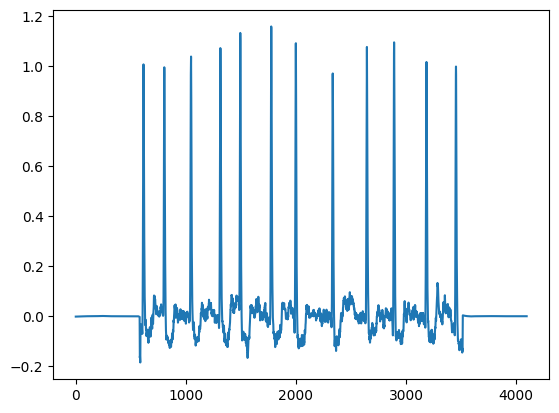

In [31]:
X = carregar_ecgs(normal=0,umdavb=0,rbbb=0,lbbb=0,sb=0,st=0,af=100,filtrado=True)

plt.plot(X[0][0])

/tmp/ipykernel_1045558/1192395905.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


Epoch 0: Train Loss = 2.0676, Val Loss = 2.0473, Val Acc = 0.1714, Val F1 = 0.1317
Epoch 1: Train Loss = 2.0426, Val Loss = 2.0203, Val Acc = 0.1714, Val F1 = 0.1359
Epoch 2: Train Loss = 2.0460, Val Loss = 2.0095, Val Acc = 0.2143, Val F1 = 0.1674
Epoch 3: Train Loss = 2.0372, Val Loss = 2.0072, Val Acc = 0.1429, Val F1 = 0.0794
Epoch 4: Train Loss = 2.0414, Val Loss = 1.9918, Val Acc = 0.1143, Val F1 = 0.0802
Epoch 5: Train Loss = 2.0182, Val Loss = 1.9919, Val Acc = 0.1714, Val F1 = 0.1178
Epoch 6: Train Loss = 2.0144, Val Loss = 1.9955, Val Acc = 0.1714, Val F1 = 0.1066
Epoch 7: Train Loss = 2.0038, Val Loss = 2.0165, Val Acc = 0.2143, Val F1 = 0.1590
Epoch 8: Train Loss = 2.0204, Val Loss = 1.9839, Val Acc = 0.1429, Val F1 = 0.0816
Epoch 9: Train Loss = 1.9909, Val Loss = 1.9868, Val Acc = 0.2000, Val F1 = 0.1046
Epoch 10: Train Loss = 1.9840, Val Loss = 1.9742, Val Acc = 0.2286, Val F1 = 0.1420
Epoch 11: Train Loss = 1.9822, Val Loss = 2.0266, Val Acc = 0.2000, Val F1 = 0.1305
Ep

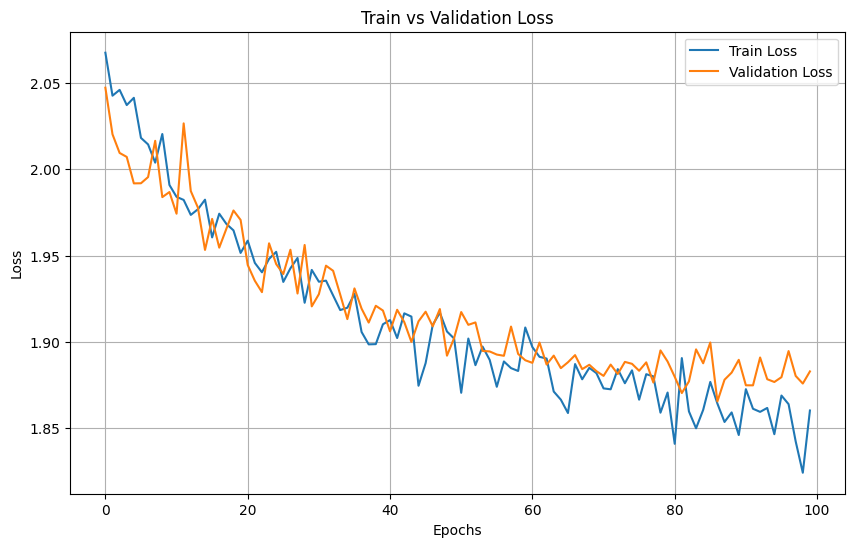

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch.optim as optim
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Lista de classes
classes = ['umdavb', 'rbbb', 'lbbb', 'sb', 'st', 'af', 'normal']
num_classes = len(classes)

class ResidualGCNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super(ResidualGCNBlock, self).__init__()
        self.conv = GCNConv(in_channels, out_channels)
        self.bn = torch.nn.BatchNorm1d(out_channels)
        self.res_lin = torch.nn.Linear(in_channels, out_channels) if in_channels != out_channels else None
        self.dropout = dropout

    def forward(self, x, edge_index):
        x_in = x  # Residual connection
        x = self.conv(x, edge_index)
        x = self.bn(x)
        x = F.relu(x)

        if self.res_lin is not None:
            x_in = self.res_lin(x_in)

        x = x + x_in  # Add residual connection
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x

class ResidualGCNClassifier(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super(ResidualGCNClassifier, self).__init__()
        self.block1 = ResidualGCNBlock(num_features, hidden_dim, dropout=dropout)
        self.block2 = ResidualGCNBlock(hidden_dim, hidden_dim, dropout=dropout)
        self.block3 = ResidualGCNBlock(hidden_dim, hidden_dim, dropout=dropout)

        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim * 2)
        self.bn_mlp = torch.nn.BatchNorm1d(hidden_dim * 2)
        self.lin2 = torch.nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.block1(x, edge_index)
        x = self.block2(x, edge_index)
        x = self.block3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = self.lin1(x)
        x = self.bn_mlp(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        return x


def train(loader, model, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)  # shape: [batch_size, num_classes]
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(loader, model, device):
    model.eval()
    total_loss = 0
    preds = []
    trues = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)  # [batch_size, num_classes]
            loss = criterion(out, batch.y)
            total_loss += loss.item() * batch.num_graphs
            pred = torch.argmax(out, dim=1)  # classe predita
            true = batch.y  # classe verdadeira
            preds.append(pred.cpu())
            trues.append(true.cpu())
    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()
    acc = (preds == trues).mean()
    f1 = f1_score(trues, preds, average='macro')
    return total_loss / len(loader.dataset), acc, f1

if __name__ == "__main__":
    # Arquivos por classe (um arquivo .pt por classe)
    class_files = [
        'grafos/umdavb.pt',
        'grafos/rbbb.pt',
        'grafos/lbbb.pt',
        'grafos/sb.pt',
        'grafos/st.pt',
        'grafos/af.pt',
        'grafos/normais.pt'
    ]

    class ECGVisibilityGraphsDataset(InMemoryDataset):
        def __init__(self, root, class_files, classes, transform=None, pre_transform=None):
            self.class_files = class_files
            self.classes = classes
            self._num_classes = len(classes)
            super(ECGVisibilityGraphsDataset, self).__init__(root, transform, pre_transform)
            self.data, self.slices = torch.load(self.processed_paths[0])

        @property
        def processed_file_names(self):
            return ['data.pt']

        def process(self):
            data_list = []
            for i, pt_path in enumerate(self.class_files):
                saved_data = torch.load(pt_path)
                grafos = saved_data['grafos']
                for g in grafos:
                    src = g['src']
                    dst = g['dst']
                    num_nodes = max(src.max().item(), dst.max().item()) + 1
                    F_dim = 16
                    x = torch.ones((num_nodes, F_dim), dtype=torch.float)
                    edge_index = torch.stack([src, dst], dim=0)

                    y = torch.tensor(i, dtype=torch.long)
                    data = Data(x=x, edge_index=edge_index, y=y)
                    data_list.append(data)

            if self.pre_filter is not None:
                data_list = [d for d in data_list if self.pre_filter(d)]

            if self.pre_transform is not None:
                data_list = [self.pre_transform(d) for d in data_list]

            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])

    dataset = ECGVisibilityGraphsDataset(root='.', class_files=class_files, classes=classes)
    dataset = dataset.shuffle()
    n = len(dataset)
    train_len = int(0.8 * n)
    val_len = int(0.1 * n)
    test_len = n - train_len - val_len

    train_dataset = dataset[:train_len]
    val_dataset = dataset[train_len:train_len+val_len]
    test_dataset = dataset[train_len+val_len:]

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = ResidualGCNClassifier(num_features=16, hidden_dim=32, num_classes=num_classes, dropout=0.2).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(100):
        train_loss = train(train_loader, model, optimizer, criterion, device)
        val_loss, val_acc, val_f1 = evaluate(val_loader, model, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, Val F1 = {val_f1:.4f}")

    test_loss, test_acc, test_f1 = evaluate(test_loader, model, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")

    # Plotting the train and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(100), train_losses, label='Train Loss')
    plt.plot(range(100), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    torch.save(model.state_dict(), "modelo_treinado.pt")


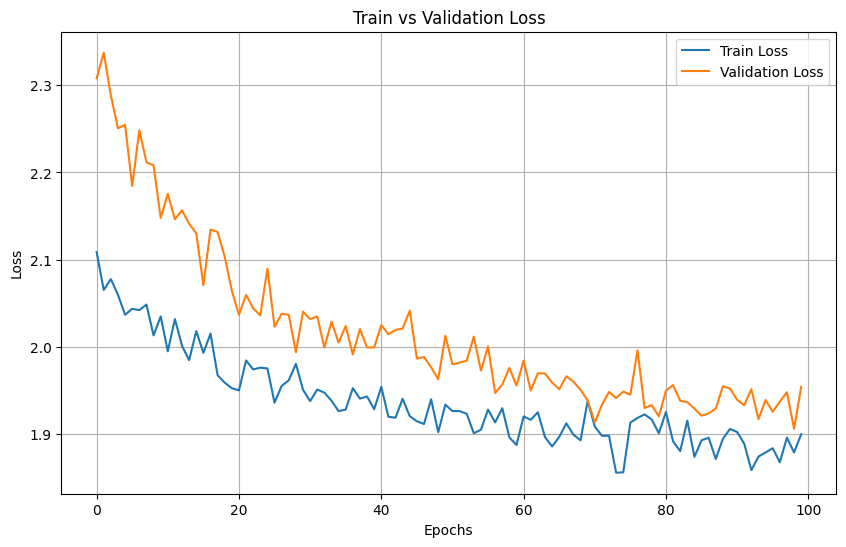

In [6]:
    # Plotting the train and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(100), train_losses, label='Train Loss')
    plt.plot(range(100), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
# Importação de bibliotecas necessárias
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GAE
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils import negative_sampling, add_self_loops, remove_self_loops
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

# Definição do dispositivo (CPU ou GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carregamento do arquivo .pt
data = torch.load('normais.pt')
grafos = data['grafos']
vetores = data['vetores']  # Assumindo que este é um tensor de forma [num_grafos, num_nos]

# Preparação dos dados: criação de objetos Data para cada grafo
data_list = []
for idx, grafo in enumerate(grafos):
    src = grafo['src']
    dst = grafo['dst']
    edge_index = torch.stack([src, dst], dim=0)
    # Remover self-loops, se existirem
    edge_index, _ = remove_self_loops(edge_index)
    # Adicionar self-loops (opcional, dependendo do modelo)
    edge_index, _ = add_self_loops(edge_index)

    # Features dos nós: usar os valores originais dos vetores
    # Features dos nós: usar os valores originais dos vetores
    x = vetores[idx]  # Tensor de forma [num_nos]
    x = torch.tensor(x).unsqueeze(1).float()  # Converter para tensor PyTorch, forma [num_nos, 1]

    # Padronização: média 0, desvio padrão 1
    mean = x.mean(dim=0, keepdim=True)  # Média por feature
    std = x.std(dim=0, keepdim=True)    # Desvio padrão por feature
    x = (x - mean) / std                # Aplicar padronização

    # Criação do objeto Data
    data_item = Data(x=x, edge_index=edge_index)
    # Divisão das arestas para treinamento, validação e teste
    data_item = train_test_split_edges(data_item)
    data_list.append(data_item)

# Definição do modelo GAT Autoencoder complexo
class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=4):
        super(GATEncoder, self).__init__()
        # Camada GATConv inicial
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=0.2)
        # Camadas intermediárias com skip connections
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=0.2)
        self.conv3 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=0.2)
        # Camada final para obter o embedding de tamanho desejado
        self.conv4 = GATConv(hidden_channels * num_heads, out_channels, heads=1, concat=False, dropout=0.2)

    def forward(self, x, edge_index):
        x1 = F.elu(self.conv1(x, edge_index))
        x2 = F.elu(self.conv2(x1, edge_index))
        x3 = F.elu(self.conv3(x2 + x1, edge_index))  # Skip connection
        z = self.conv4(x3 + x2 + x1, edge_index)     # Skip connection
        return z

# Definição do modelo GAE com o encoder GAT
in_channels = 1  # Número de features de entrada por nó
hidden_channels = 64  # Tamanho das camadas ocultas
out_channels = 16  # Número de features latentes desejadas por nó
encoder = GATEncoder(in_channels, hidden_channels, out_channels).to(device)
model = GAE(encoder).to(device)

# Definição do otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# Função de treinamento
def train(data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

# Função de teste com cálculo da AUC ROC e AP
@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))

    # Cálculo da perda de reconstrução
    loss = model.recon_loss(z, data.test_pos_edge_index.to(device))
    
    # Cálculo das métricas AUC e AP
    pos_edge_index = data.test_pos_edge_index.to(device)
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index.to(device),
        num_nodes=data.num_nodes,
        num_neg_samples=pos_edge_index.size(1),
        method='sparse')

    # Probabilidades para arestas positivas e negativas
    pos_pred = model.decoder(z, pos_edge_index).squeeze()
    neg_pred = model.decoder(z, neg_edge_index).squeeze()

    preds = torch.cat([pos_pred, neg_pred]).cpu()
    labels = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))])

    auc = roc_auc_score(labels.numpy(), preds.numpy())
    ap = average_precision_score(labels.numpy(), preds.numpy())

    return loss.item(), auc, ap

# Loop de treinamento
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    total_loss = 0
    for data_item in data_list:
        loss = train(data_item)
        total_loss += loss
    avg_loss = total_loss / len(data_list)
    print(f'Epoch {epoch:02d}, Loss: {avg_loss:.4f}')

    # Avaliação no final de cada época (opcional)
    if epoch % 5 == 0:
        total_loss = 0
        total_auc = 0
        total_ap = 0
        for data_item in data_list:
            loss, auc, ap = test(data_item)
            total_loss += loss
            total_auc += auc
            total_ap += ap
        avg_loss = total_loss / len(data_list)
        avg_auc = total_auc / len(data_list)
        avg_ap = total_ap / len(data_list)
        print(f'Validation Loss: {avg_loss:.4f}, AUC: {avg_auc:.4f}, AP: {avg_ap:.4f}')

# Após o treinamento, obtenha os embeddings com 3 features por nó
embeddings_list = []
model.eval()
with torch.no_grad():
    for data_item in data_list:
        z = model.encode(data_item.x.to(device), data_item.train_pos_edge_index.to(device))
        embeddings_list.append(z.cpu())

# Salvar os embeddings para uso futuro
torch.save({'embeddings': embeddings_list}, 'embeddings_gat_autoencoder.pt')
print("Embeddings salvos em 'embeddings_gat_autoencoder.pt'.")


/tmp/ipykernel_1030795/1932111482.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('normais.pt')
/home/grad/si/24/guilherme.evangelista/anaconda3/envs/

Epoch 01, Loss: 1.3913
Epoch 02, Loss: 1.3317
Epoch 03, Loss: 1.3359
Epoch 04, Loss: 1.3326
Epoch 05, Loss: 1.3309
Validation Loss: 1.3183, AUC: 0.6773, AP: 0.6813
Epoch 06, Loss: 1.3246
Epoch 07, Loss: 1.3202
Epoch 08, Loss: 1.3154
Epoch 09, Loss: 1.3100
Epoch 10, Loss: 1.3030
Validation Loss: 1.2985, AUC: 0.7001, AP: 0.6933
Epoch 11, Loss: 1.2965
Epoch 12, Loss: 1.2895
Epoch 13, Loss: 1.2831
Epoch 14, Loss: 1.2775
Epoch 15, Loss: 1.2716
Validation Loss: 1.2739, AUC: 0.7435, AP: 0.7230
Epoch 16, Loss: 1.2674
Epoch 17, Loss: 1.2622
Epoch 18, Loss: 1.2577
Epoch 19, Loss: 1.2529
Epoch 20, Loss: 1.2486
Validation Loss: 1.2510, AUC: 0.7723, AP: 0.7463
Epoch 21, Loss: 1.2456
Epoch 22, Loss: 1.2419
Epoch 23, Loss: 1.2387
Epoch 24, Loss: 1.2355
Epoch 25, Loss: 1.2317
Validation Loss: 1.2301, AUC: 0.7938, AP: 0.7628
Epoch 26, Loss: 1.2293
Epoch 27, Loss: 1.2266
Epoch 28, Loss: 1.2229
Epoch 29, Loss: 1.2185
Epoch 30, Loss: 1.2129
Validation Loss: 1.2102, AUC: 0.8025, AP: 0.7728
Epoch 31, Loss: 